First, let's extract all articles by year 2018.

In [1]:
from collections import Counter

In [2]:
import pandas as pd
import numpy as np

In [3]:
data=pd.read_csv('art_data.csv',sep=';')[['date', 'Author']]

In [4]:
print(data)

           date                                             Author
0        1.4.16  Cashman K.D.:19133816500;Dowling K.G.:56809015...
1        1.2.16  Demaerschalk B.M.:6602774113;Kleindorfer D.O.:...
2        2.3.16                         Simopoulos A.P.:7004632919
3        1.1.16  Carson V.:35423397400;Hunter S.:56723479100;Ku...
4        1.8.16  Fothergill E.:57190387710;Guo J.:26535878900;H...
5        1.1.16                                                NaN
6        1.4.16  Correa-Oliveira R.:57203715398;Fachi J.L.:5720...
7       15.3.16  Li Y.:56032555000;Yao J.:57186007500;Han C.:57...
8       27.1.16                            Kennedy D.O.:7403112549
9        1.6.16  Turck D.:7102357517;Braegger C.P.:7004464897;C...
10       1.1.16  Akkasheh G.:55987603700;Kashani-Poor Z.:570564...
11       1.3.16  Nanditha A.:35315908700;Ma R.C.W.:8151571700;R...
12       1.1.16                          Deiuliis J.A.:14123071600
13       6.2.16  Ozdal T.:55628003500;Sela D.A.:18438273600;Xi

In [5]:
data['year'] = [date.split('.')[-1] for date in data['date'].values]
auts = data[(data.year == '18') & (data.Author != 'None') & (pd.isna(data.Author) == False)]['Author']
print(auts)

250     Pillepich A.:16679835300;Springel V.:700330715...
251     Lyu Y.:57188631496;Zeng J.:57198904939;Jiang Y...
252     Panacek A.:8661439600;Kvitek L.:6507087924;Sme...
253     Tacconi L.J.:7005805876;Genzel R.:35499152300;...
254     Gosak M.:12783091900;Markovic R.:54983377600;D...
255     Fang T.:56659054500;Lv H.:57189627714;Lv G.:57...
256     Baranov D.G.:55307905900;Wersall M.:5643680710...
257     Nam J.:26646900800;Son S.:34880858500;Ochyl L....
258     Shao P.:56410522800;Tian J.:35273800200;Yang F...
259     Weiss M.:56522195400;Frohnmayer J.P.:567659925...
260                                   Adli M.:14621562100
261     Weinhard L.:56079979500;Di Bartolomei G.:57193...
262     Springel V.:7003307156;Pakmor R.:25625718400;P...
263     Clark S.J.:56449950400;Argelaguet R.:572008592...
264     Zhang S.-Q.:57196104313;Che L.-H.:57193885397;...
265     Wang R.:57188957705;Van Dorp L.:56817011400;Sh...
266     Kind T.:13607301800;Tsugawa H.:54883759700;Caj...
267     Ramste

And then, separate the author from every paper and make list of authors with articles as their connections.

In [6]:
res={}
for i in auts:
    aus=i.split(';')
    auids=[l.split(':')[1] for l in aus]
    for j in auids:
        c=Counter([k for k in auids if k!=j])
        if j in res:
            res[j]+=c
        else:
            res[j]=c

In [7]:
edges=[]
for k, v in res.items():
    for j, w in v.items():
        edges.append((k, j, w))

We can construct co-autorships graph. Here, individual authors are nodes and common articles are edges between them.

In [8]:
import networkx as nx

In [9]:
G=nx.Graph()

In [10]:
G.add_weighted_edges_from(edges)

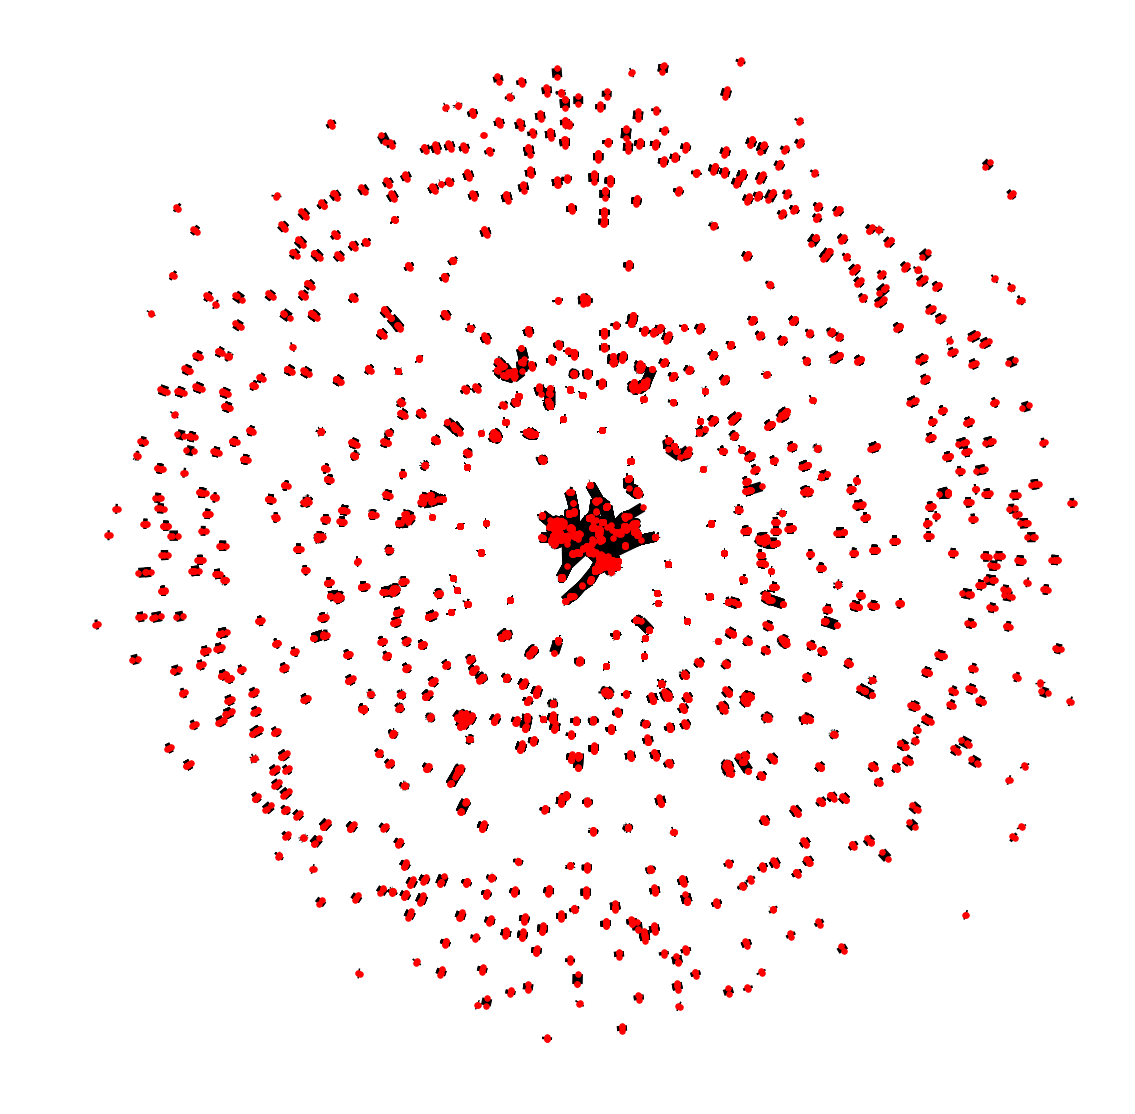

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
nx.draw(G, node_size=30, width=10)
plt.show()

In [11]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10945
Number of edges: 606602
Average degree: 110.8455


We can see that there are many disjointed connection componenets. The largest component is in the centre - but it seems too large for optimizer. Let's visit the next four biggest connected components.

In [12]:
graphs = sorted(nx.connected_component_subgraphs(G), key=len)

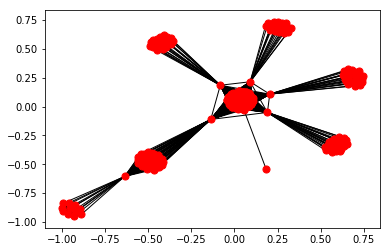

In [15]:
import matplotlib.pyplot as plt

nx.draw_networkx(graphs[-2],with_labels=False,node_size=50)
plt.show()

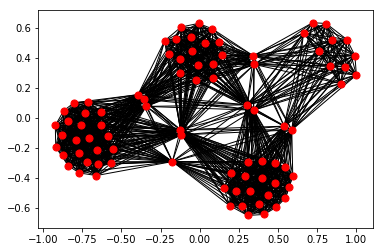

In [14]:
nx.draw_networkx(graphs[-3],with_labels=False,node_size=50)
plt.show()

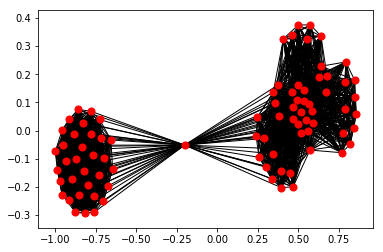

In [16]:
nx.draw_networkx(graphs[-4],with_labels=False,node_size=50)
plt.show()

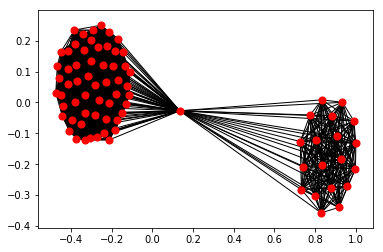

In [17]:
nx.draw_networkx(graphs[-5],with_labels=False,node_size=50)
plt.show()

So, the idea is to conect these components into one graph by bulding bridges. Let's do that.

In [18]:
import matplotlib.pyplot as plt

def add_bridge(g1, g2):
    G = nx.union(g1,g2, rename=('a-', 'b-'))
    #print(list(G.nodes)[2])
    
    G.add_edge(np.random.choice(list(G.nodes)[:len(g1)]), np.random.choice(list(G.nodes)[len(g1):]))

    return G

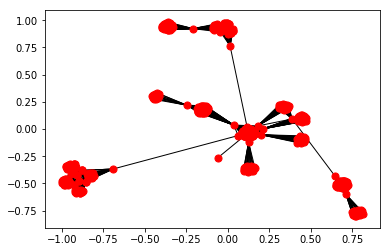

In [19]:
G = add_bridge(graphs[-2], graphs[-3])
G = add_bridge(G, graphs[-4])
G = add_bridge(G, graphs[-5])

nx.draw_networkx(G,with_labels=False,node_size=50)
plt.show()

In [20]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 549
Number of edges: 20606
Average degree:  75.0674


Here, we define the requisites fo SIR model. We have a weighted graph, so then we define infection rate coefficient beta as the ratio between edge weight (presented in adjacency matrix A) and maximum edge weight - the bigger the weight, the higher the probability for infection spread. The maximum probability is 0.95 - because everybody should have a chance.

For gamma, we have a dynamic definition - it stays zero on days 1-3 (as in the description, you can recover only on days 3 to 7, then it grows by 0.25 each day until day 7).

In [21]:
from scipy.integrate import odeint
from numba import jit

np.random.seed(42)

n = len(G)
print(n)

A = np.array(nx.adj_matrix(G).todense())
print(A)

# Spreading\restoring coefficient
beta, days_to_recover = 0.95/np.max(A), np.full(n,-2.)

# Time domain
t = np.arange(0,101,1)

idx = np.random.choice(range(n), int(0.02*549))
i0 = np.zeros((n,))
i0[idx] = 1
# i0 = np.random.random_integers(0,1,[n,])
z0 = np.concatenate((1-i0,i0,np.zeros((n,))))

549
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


Here are the ODEs for SIR task. We discussed in the previous section the changes we made to coefficients
\begin{equation}
   \begin{cases}
   \cfrac{ds_i(t)}{dt} = -\beta s_i(t)\sum\limits_j A_{ij} x_j(t)\\
   \cfrac{dx_i(t)}{dt} = \beta s_i(t)\sum\limits_j A_{ij} x_j(t) - \gamma x_i(t)\\
   \cfrac{dr_i(t)}{dt} = \gamma x_i(t)
  \end{cases}
  \\
  x_i(t) + s_i(t) + r_i(t) = 1
\end{equation}

In [22]:
@jit
def sir(z, t, A, n, beta, days_to_recover):
    days_to_recover += np.fix(z[n:2*n])
    gamma = np.clip(1/4*days_to_recover, 0, 1)
    return np.concatenate((
        -beta * z[0:n] * A.dot(z[n:2*n]),
         beta * z[0:n] * A.dot(z[n:2*n]) - gamma * z[n:2*n],
         gamma * z[n:2*n]
        ))

In [23]:
%%time
z = odeint(sir, z0, t, (A, n, beta, days_to_recover))

CPU times: user 1min 43s, sys: 2min 50s, total: 4min 33s
Wall time: 35 s


Here is how amount of nodes in each class changes over time.

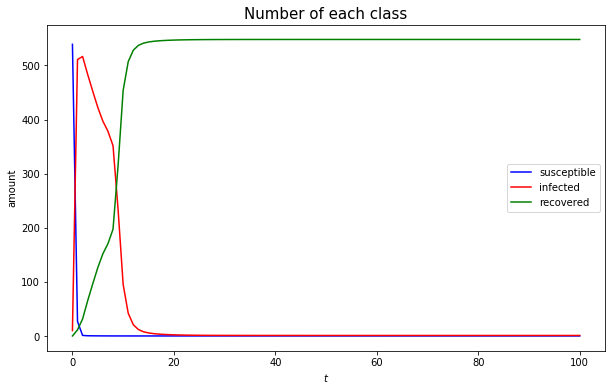

In [24]:
nId = 6
s1 = np.sum(z[:,0:n], axis=1)
x1 = np.sum(z[:,n:2*n], axis=1)
r1 = np.sum(z[:,2*n:3*n], axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s1,color = 'blue', label='susceptible')
ax.plot(x1,color = 'red', label='infected')
ax.plot(r1,color = 'green', label='recovered')
ax.set_xlabel('$t$')
ax.set_ylabel('amount')
ax.set_title('Number of each class', fontsize = 15)
ax.legend()

Here, we propose vaccination strategy. The simpliest thing we can do is to ignore infected and try to secure the most central nodes in the graph so that the infected ones would be isolated. To do that, betweenness centrality fits the best, as it measures how many shortest ways of possible ones comes through this node with the weight in reagrd.

In [25]:
centrality = nx.betweenness_centrality(G, weight = 'weight')
ids = range(len(G))

ids = [x for _,x in sorted(zip(list(centrality.values()),ids), reverse=True)]

print(ids)

[80, 284, 200, 459, 350, 182, 531, 262, 447, 76, 512, 64, 10, 250, 334, 319, 327, 302, 354, 345, 325, 388, 386, 359, 468, 460, 454, 452, 437, 431, 429, 422, 421, 410, 408, 402, 398, 397, 395, 274, 466, 461, 449, 418, 352, 346, 328, 451, 450, 411, 403, 432, 427, 426, 420, 417, 400, 445, 443, 441, 435, 434, 433, 425, 394, 391, 471, 440, 438, 428, 419, 414, 412, 409, 393, 392, 390, 377, 367, 366, 362, 357, 355, 344, 339, 338, 332, 322, 321, 320, 305, 304, 303, 384, 380, 378, 372, 369, 364, 361, 356, 348, 342, 336, 335, 324, 318, 314, 313, 312, 311, 310, 309, 306, 383, 381, 373, 365, 360, 358, 343, 340, 333, 331, 323, 385, 382, 379, 376, 375, 374, 371, 370, 368, 363, 353, 351, 349, 347, 341, 337, 330, 329, 326, 317, 316, 315, 308, 307, 548, 547, 546, 545, 544, 543, 542, 541, 540, 539, 538, 537, 536, 535, 534, 533, 532, 530, 529, 528, 527, 526, 525, 524, 523, 522, 521, 520, 519, 518, 517, 516, 515, 514, 513, 511, 510, 509, 508, 507, 506, 505, 504, 503, 502, 501, 500, 499, 498, 497, 496, 495

In [26]:
centr_vac_ids = ids[:int(len(G) / 10)]
print(centr_vac_ids)

[80, 284, 200, 459, 350, 182, 531, 262, 447, 76, 512, 64, 10, 250, 334, 319, 327, 302, 354, 345, 325, 388, 386, 359, 468, 460, 454, 452, 437, 431, 429, 422, 421, 410, 408, 402, 398, 397, 395, 274, 466, 461, 449, 418, 352, 346, 328, 451, 450, 411, 403, 432, 427, 426]


For each vaccinated node, we remove the susception if it is susceptible and put it in recovered category.

In [27]:
for ind in centr_vac_ids:
    z0[ind] = 0
    z0[2*n + ind] = 1

In [28]:
print(z0)

[1. 1. 1. ... 0. 0. 0.]


Now, let's solve the equations. We can see that infection was wiped out significantly faster and number of susceptible stayed high.

In [29]:
%%time
z = odeint(sir, z0, t, (A, n, beta, days_to_recover))

CPU times: user 12.5 s, sys: 21 s, total: 33.5 s
Wall time: 4.33 s


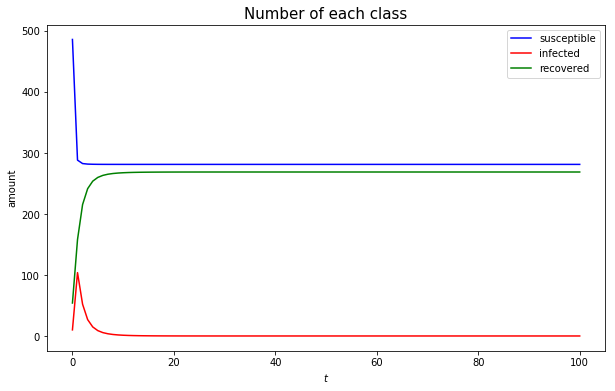

In [30]:
nId = 6
s2 = np.sum(z[:,0:n], axis=1)
x2 = np.sum(z[:,n:2*n], axis=1)
r2 = np.sum(z[:,2*n:3*n], axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s2,color = 'blue', label='susceptible')
ax.plot(x2,color = 'red', label='infected')
ax.plot(r2,color = 'green', label='recovered')
ax.set_xlabel('$t$')
ax.set_ylabel('amount')
ax.set_title('Number of each class', fontsize = 15)
ax.legend()

Now, let's count treatment cost as proposed in the task. Number of vaccinations was fixed to 10 per cent. For each recovered person per turn, let's suppose that we needed to treat him but there is a small room (5%) for such a wonder that the patient was self-healed successfully.

In [31]:
def count_cost(s, x, r):
    vaccination = 500 * int(r[0])
    healings = np.sum(np.fix(r - np.roll(r,1))[1:].astype(int))
    treatment = 0
    for i in range(healings):
        eps = np.random.uniform(0,1)
        if eps > 0.95:
            continue
        else:
            treatment += 120
    cost = vaccination + treatment
    return cost

In [32]:
print(count_cost(s1, x1, r1))
print(count_cost(s2, x2, r2))

60840
51120


Let's modificate the idea. We can use graph clustering to detect some clusters.

In [33]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(int(0.01*len(G)), affinity='precomputed', n_init=100)
sc.fit(A)
clusters = sc.labels_
print(sc.labels_)

[0 0 0 1 1 1 3 0 3 1 0 1 0 0 1 0 1 0 0 0 1 3 0 1 0 0 0 0 0 0 1 0 1 3 0 0 1
 0 0 0 3 1 0 0 1 0 0 0 0 0 0 0 0 1 1 3 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0
 1 3 0 0 0 0 0 0 0 0 0 3 3 0 3 0 1 0 1 0 0 0 0 1 1 3 0 1 0 1 0 0 0 1 3 1 0
 0 0 0 1 0 0 0 0 0 3 0 0 1 1 1 0 1 0 3 1 0 0 0 3 0 0 0 1 3 1 3 1 3 3 1 0 1
 0 0 0 0 0 0 0 1 3 3 3 3 3 1 3 3 1 0 0 0 0 0 1 1 3 1 0 0 0 0 0 1 0 1 1 3 1
 1 3 0 1 3 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 3 1 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 0 0 1 1 0 3 0 1 1 0 3 1 0 0 1 0 0 0 0 0 1 1 1 0 0 3 1 1 0 0 1 0 3 0
 0 1 0 0 1 1 0 3 0 0 1 0 0 1 1 0 0 0 1 0 0 3 0 0 0 0 0 3 3 3 1 0 0 1 1 1 0
 0 1 0 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 1 2 2 2 1 2 2 1
 2 2 2 1 2 2 2 2 2 2 2 1 

Now, for each cluster, select fixed amount of central nodes by same centrality.

In [34]:
cluster_ids = []

for label in range(int(0.01*len(G))):
    ids = list(np.where((clusters == label) * range(len(G)) > 0))[0]
    centr_label = np.take((clusters == label) * list(centrality.values()),ids)
    ids = [x for _, x in sorted(zip(centr_label,ids), reverse=True)]
    cluster_ids += ids[:10]

In [35]:
print(cluster_ids)

[80, 284, 200, 262, 76, 64, 10, 274, 300, 298, 350, 182, 334, 319, 327, 302, 354, 345, 325, 386, 531, 512, 548, 547, 546, 545, 544, 543, 542, 540, 250, 299, 288, 287, 286, 280, 266, 257, 235, 230, 459, 447, 388, 468, 460, 454, 452, 437, 431, 429]


In [36]:
z0 = np.concatenate((1-i0,i0,np.zeros((n,))))

In [37]:
for ind in cluster_ids:
    z0[ind] = 0
    z0[2*n + ind] = 1

In [38]:
%%time
z = odeint(sir, z0, t, (A, n, beta, days_to_recover))

CPU times: user 13.3 s, sys: 22.8 s, total: 36.1 s
Wall time: 4.78 s


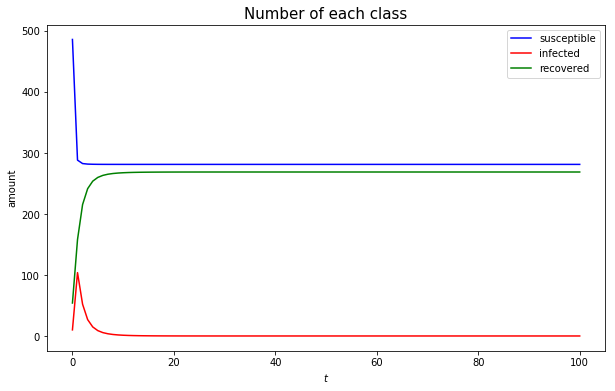

In [39]:
nId = 6
s3 = np.sum(z[:,0:n], axis=1)
x3 = np.sum(z[:,n:2*n], axis=1)
r3 = np.sum(z[:,2*n:3*n], axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(s2,color = 'blue', label='susceptible')
ax.plot(x2,color = 'red', label='infected')
ax.plot(r2,color = 'green', label='recovered')
ax.set_xlabel('$t$')
ax.set_ylabel('amount')
ax.set_title('Number of each class', fontsize = 15)
ax.legend()

In [40]:
print(count_cost(s3, x3, r3))

57640


Unfortunately, this solution doesn't make any difference.

A more effective solution can be proposed (unfortunately, no time to code this). We can use that we know before the simulation which nodes exactly were infected. We know that the probability of spreading the infection is higher as the weight grows up. That's why a good idea would be to vaccinate the neighbours of infected person who have the highest connection weight. We can do that 